In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from itertools import product
from sklearn.preprocessing import label_binarize

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2482)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    #'subject_len': mail_dict['subject_len'],
                    #'body_len': mail_dict['body_len'],
                    #'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    #'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    #'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    #'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    #'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    #'return_path_match_from': mail_dict['return_path_match_from'],
                    #'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    #'Content-type': mail_dict['Content-type'],
                    #'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    #'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    #'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    #'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    #'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    #'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    #'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    #'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    #'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    #'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    #'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    #'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    #'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    #'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    #'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    #'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    #'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    #'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    #'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    #'has_defects': mail_dict['has_defects'],
                    #'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    #'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE YAX-80-97157 Tom Jensen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- lmportant Message.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[1].eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Hope all your Christmas dreams come true!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment issue 2.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Ship Notification, Tracking Number 0RRN19486604712021.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Voice message from WIRELESS CALLER +1 718-963-4062).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Ren Hart used Dropbox to share a folder with you.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Paypal Receipt.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- kantonena@mediastrom.gr has shared a document on SharePoint Online..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Proposal - Kuhn Construction .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish A

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [SPAM] New payment notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Shipment Notification[2].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Division6.4 LLC share a document Via DOCUSIGN.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Office 365 Suspension.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Past due Invoice 694630161.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Rechnung 11-2017 913773856.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- WeI have a footage of you milking your dog, you will be excited.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Recognition Concepts Contract.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- You Have Received New Invoice Document.eml


/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment notice for invoice #1647302.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Recent payment notification to Carol Rusten.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Express Domestic.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Yоu hаvе thе tаlеnt tо роsе fоr thе саmеrа, dоn't bе nеrvоus..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Coseco Invoice IR1-52583.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- IMPORTANT MAIL.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pay Invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice #9066829 from Lori Whitesides.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] IMPORTANT - William Olberding  Invitation to view..eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Ship Notification, Tracking Number 7M01917345053585.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Elaine Tracey Software virus on your gadget ID et8zt7Zbz3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payroll Update.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Record of Account Transcript from June 13, 2018.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Shipment Notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pay Invoice[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Awaiting for your confirmation.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Please pull invoice 969295.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Investment...eml
/Users/worshamn/Documents/e

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- iPhone 8. Apple Watch Series 3. Pre-order now..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- This is the secret to Eva Longoria's ageless beauty.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- View Tanya Spiridon's Contact Info and Background Report Now.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Cyber Week Special on Christmas Wristbands.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Happy Halloween!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Save the Date- AHOU 2018 Annual Conference.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The ultimate resource for GDPR readiness.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Final Days of Sale- Extra 20% Off.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Friendly Reminder- A

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Facebook to Keynote; Register Now.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- your annual bc-dr planning goal.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The Perfect Cup Of Coffee!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- AMANDA, $267.17 Bank Deposit....eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Guaranteed employment and a 50k salary.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- $200M Lost for A.P. Moller-Maersk from Ransomware • Confirmed Speakers for Cyber Risk NY •  Connect & Learn at Upcoming Conferences, Webinars & More....eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Gartner announces agenda for Data & Analytics Summit.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You can beat addiction - with help.eml
/Users/worshamn/Docu

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your binge drinking is destroying you.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Important- Your Attention is Needed Today.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You'll never believed the real reason she was fired.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- IMPORTANT- Updated Privacy Policy, Action Required.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- MS Excel- Advanced Reporting with Power Pivot and Power Query.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Knock Out Some CE with Our NO-EXAM Webinars!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Work From Home Programs Do's and Don'ts - Register Today.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Hi .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- CBD oil

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\]'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Best marketing solution for Pinnacol Assurance.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] hiring Colorado talent.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Save $1,100 thru Friday  Get In-Depth Knowledge.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Email Account Hacked.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You need to lower your blood pressure.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Demo for new Digital Customer Onboarding.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- MICHAEL! You are PRE-APPROVED!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Confront Industry Transitions  Save $1,000.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Email.eml
/Users/worshamn/Documents/emailProject/IgnoreF

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- mPower March Insights- Predictive Analytics in Workers' Comp and Visualizing Claims Data.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- → 8 Jobs for Medical Payments Services Manager - Denver.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Includes- Apple's Great Marketing Trick Roman Numerals.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Sign Up Today! Health Headliners pres. Eric Neufeld on Prosthetics.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Letters of Credit for Importers - Exporters.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Is Governance Your Glue or Your Red Tape.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- We’re updating our terms of use and privacy policy.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- email verification today.eml
/U

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Response Requested Am I Being Buried.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The Golf Wire- Nemacolin Woodlands Resort offers fall specials; C.W. Golf Architecture develops plan for CC of Jackson; and more.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Need some extra Christmas funds.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Prime Santa Fe Value-Add Anchored Retail Asset With Substantial Upside.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Virtual event] See a demo of chatbots in action.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Health Insurances .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Evaluating Our Solutions Join Us and Save 50%.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Interested in becoming a Certified Ethical

Convert cells that are not recognized as a number or just to get rid of float

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
target    784 non-null object
text      784 non-null object
dtypes: object(2)
memory usage: 12.3+ KB


Create a function to clean the text

In [11]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
    #         stopwords_nltk = sorted(nltk.corpus.stopwords.words('english'))
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Clean the text

In [12]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 10.248s


In [13]:
df['cleaned_text'] = pd.Series(corpus).values

In [14]:
df.sample(10,random_state=123)

,target,text,cleaned_text
384,ignore,Get the most out of your studies Hey Sabrina.w...,study hey sabrinawillishaywood mention have tr...
164,investigate,Payment to Transaction # 68M6WZF3N84J45K ...,payment transaction mwzfnjk hi amanda...
729,ignore,You could have a $55k salary who lived in engl...,k salary live england serve wwii come boston b...
689,ignore,A Special Message From MTI CAN’T SEE IMAGE? CL...,special message mti not image click img ...
200,investigate,100.net; s 161025; h=x-gm-message-state:date...,net s hxgmmessagestatedatefromtomessageid...
776,ignore,Prime Santa Fe Value-Add Anchored Retail Asset...,prime santa fe valueadd anchor retail asset su...
476,ignore,Share Your Feedback â Win an Instant Pot We’...,share feedback â win instant pot be give awa...
378,investigate,ShareFile Message From: Scott Houge ShareFile ...,sharefile message scott houge sharefile encryp...
565,ignore,Big announcements from our September event. ...,big announcement september event monumen...
392,ignore,Two sisters want you to try what they discover...,sister want try discover michellebarne be sorr...


Split the sample set into test and training sets

In [15]:
df_target = df['target']
df_feats = df['cleaned_text']
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350,
    stratify=df_target
)

#### TFIDF Creation

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=True
)
train_feats = vectorizer.fit_transform(train_feats.values.tolist())
test_feats = vectorizer.transform(test_feats.values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.464s


In [17]:
train_feats.shape

(627, 8983)

In [18]:
test_feats.shape

(157, 8983)

In [19]:
train_labels.value_counts()

ignore         320
investigate    307
Name: target, dtype: int64

In [20]:
test_labels.value_counts()

ignore         80
investigate    77
Name: target, dtype: int64

#### LSA

In [21]:
svd = TruncatedSVD(n_components=100)
train_feats = svd.fit_transform(train_feats)
train_feats.shape

(627, 100)

In [22]:
test_feats = svd.transform(test_feats)
test_feats.shape

(157, 100)

In [23]:
type(train_feats)

numpy.ndarray

In [24]:
train_feats.view()

array([[ 1.34521727e-01,  6.71178616e-01, -1.52784264e-01, ...,
         1.40972453e-02,  4.61845992e-02,  2.95680051e-04],
       [ 7.43487860e-02, -2.30704233e-02, -4.46395105e-02, ...,
         7.40616447e-02, -1.38176149e-02, -1.22926205e-02],
       [ 1.39733307e-01, -3.94752654e-02, -6.14600352e-02, ...,
        -7.22241230e-02,  4.56659576e-03, -2.76815174e-02],
       ...,
       [ 1.83712787e-01, -4.80468774e-02, -7.56533775e-02, ...,
        -3.35822800e-02,  1.55452282e-02, -2.80398713e-02],
       [ 6.17917509e-02,  1.61936919e-02, -1.37811454e-02, ...,
         1.04054530e-02,  2.73694352e-03,  7.00720787e-02],
       [ 1.24907414e-01,  1.23676059e-02,  5.27804760e-02, ...,
        -7.02276485e-02,  2.93229693e-02, -4.03573137e-02]])

Function to keep track of scoring and for printing results out

In [25]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    try:
        already_seen = clf.score(train_feats, train_labels)
        accuracy = clf.score(test_feats, test_labels)
        pred = clf.predict(test_feats)
    except:
        already_seen = clf.score(train_feats.toarray(), train_labels)
        accuracy = clf.score(test_feats.toarray(), test_labels)
        pred = clf.predict(test_feats.toarray())
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [26]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.011s
LinearSVC Scores:

Accuracy of data already seen: 0.9633
Accuracy of data not seen: 0.9490
F1 score: 0.9467
False Negatives: 6


In [27]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 0.065s
SVC Scores:

Accuracy of data already seen: 0.5104
Accuracy of data not seen: 0.5096
F1 score: 0.0000
False Negatives: 77


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Extra Trees Classifier

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 0.285s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9236
F1 score: 0.9189
False Negatives: 9


Get Feature Importances

In [29]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. 2 (0.160199)
2. 1 (0.076531)
3. 3 (0.076221)
4. 4 (0.037747)
5. 0 (0.024917)
6. 9 (0.018848)
7. 12 (0.016798)
8. 14 (0.014203)
9. 15 (0.012686)
10. 16 (0.012590)
11. 19 (0.012545)
12. 56 (0.010543)
13. 21 (0.010477)
14. 28 (0.010360)
15. 27 (0.010043)
16. 41 (0.009854)
17. 11 (0.009565)
18. 8 (0.009284)
19. 6 (0.009245)
20. 7 (0.009193)
21. 44 (0.009086)
22. 20 (0.009060)
23. 65 (0.008927)
24. 18 (0.008570)
25. 37 (0.008100)


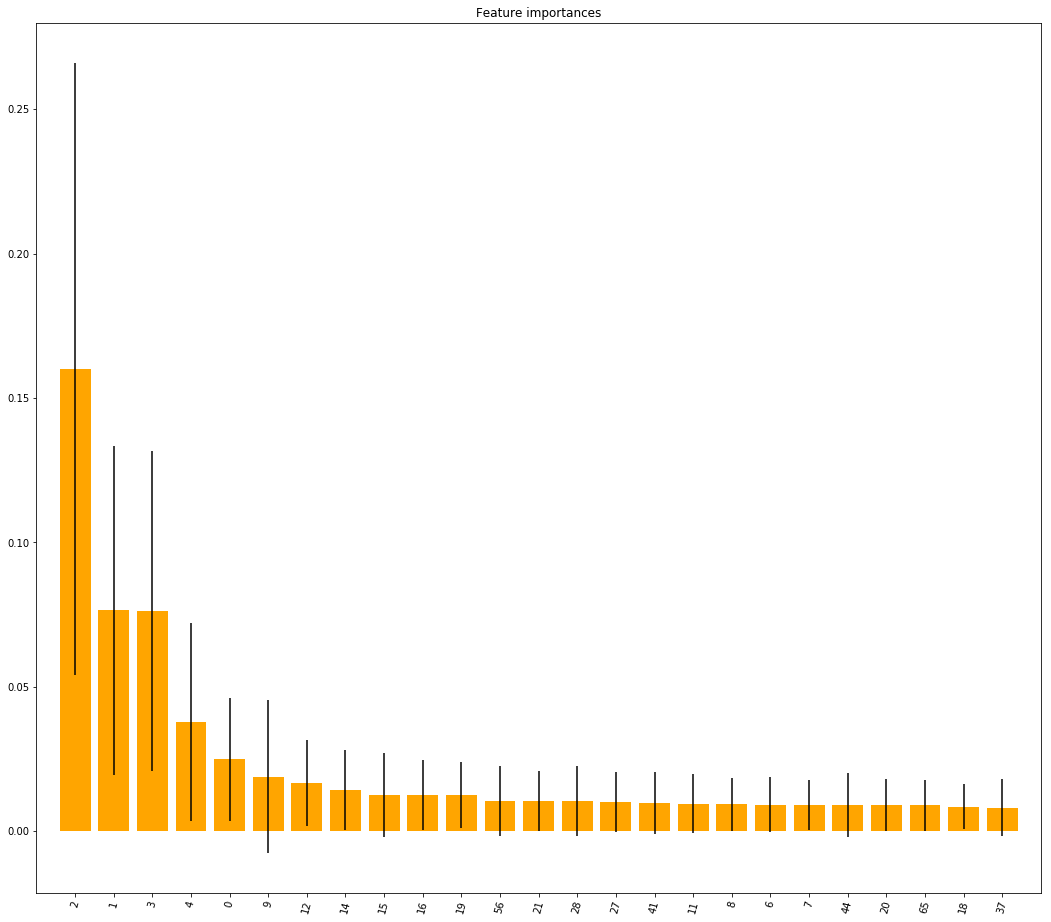

In [30]:
top_indices = indices[:25]
top_features = [i for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 0.698s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9172
F1 score: 0.9139
False Negatives: 8


#### XGBoost

In [32]:
from xgboost import XGBClassifier
t0 = time()
xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
xgb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,xgb_clf)

done in 0.522s
XGBClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9236
F1 score: 0.9231
False Negatives: 5


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Neural Net

In [33]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 0.764s
MLPClassifier Scores:

Accuracy of data already seen: 0.9872
Accuracy of data not seen: 0.9427
F1 score: 0.9404
False Negatives: 6


#### Naive Bayes

In [34]:
# from sklearn.naive_bayes import MultinomialNB
# t0 = time()
# nb_clf = MultinomialNB(alpha=.001)
# nb_clf.fit(train_feats, train_labels)
# #nb_pred = nb_clf.predict(test_feats.drop('TAP-Score',axis=1))
# print("done in %0.3fs" % (time() - t0))
# score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nb_clf)

In [35]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.003s
GaussianNB Scores:

Accuracy of data already seen: 0.9043
Accuracy of data not seen: 0.8344
F1 score: 0.8030
False Negatives: 24


#### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.286s
RandomForestClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9172
F1 score: 0.9150
False Negatives: 7


In [37]:
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. 2 (0.160199)
2. 1 (0.076531)
3. 3 (0.076221)
4. 4 (0.037747)
5. 0 (0.024917)
6. 9 (0.018848)
7. 12 (0.016798)
8. 14 (0.014203)
9. 15 (0.012686)
10. 16 (0.012590)
11. 19 (0.012545)
12. 56 (0.010543)
13. 21 (0.010477)
14. 28 (0.010360)
15. 27 (0.010043)
16. 41 (0.009854)
17. 11 (0.009565)
18. 8 (0.009284)
19. 6 (0.009245)
20. 7 (0.009193)
21. 44 (0.009086)
22. 20 (0.009060)
23. 65 (0.008927)
24. 18 (0.008570)
25. 37 (0.008100)


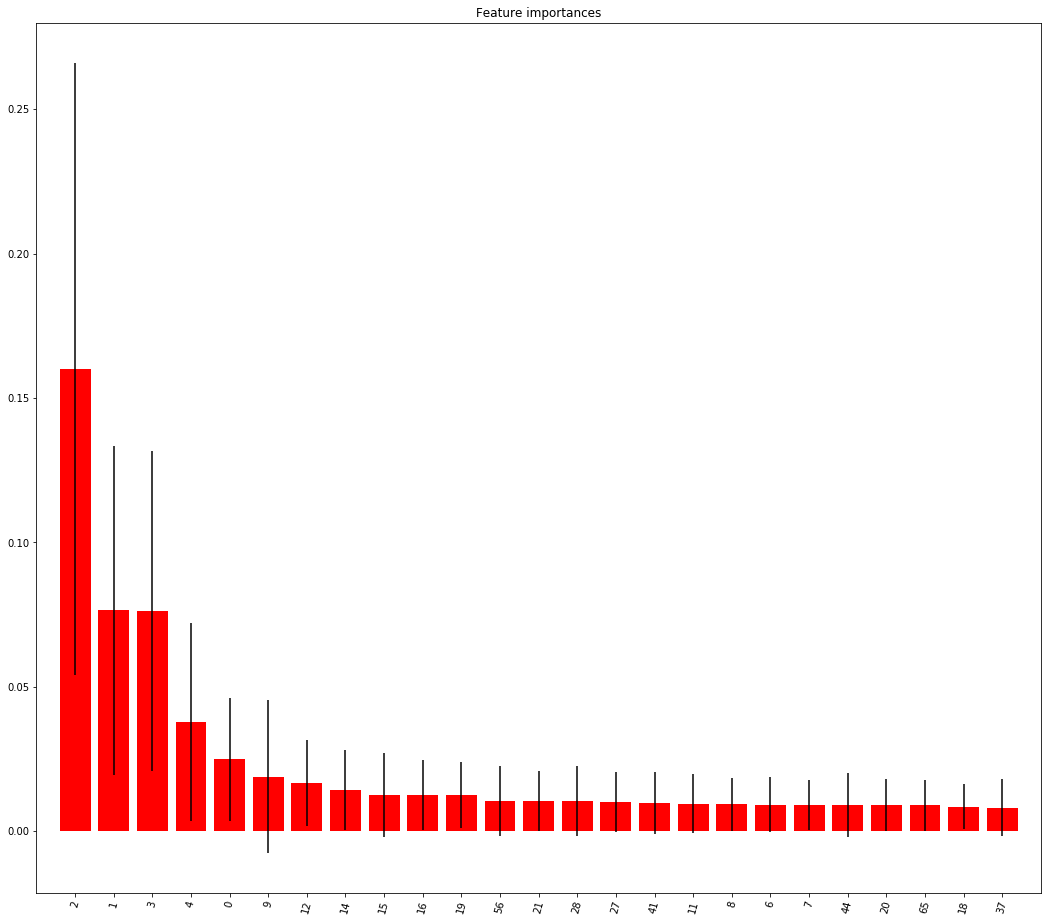

In [38]:
top_indices = indices[:25]
top_features = [i for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [39]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,knn_clf)

done in 0.002s
KNeighborsClassifier Scores:

Accuracy of data already seen: 0.9298
Accuracy of data not seen: 0.8854
F1 score: 0.8889
False Negatives: 5


#### NearestCentroid

In [40]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.002s
NearestCentroid Scores:

Accuracy of data already seen: 0.9474
Accuracy of data not seen: 0.9299
F1 score: 0.9262
False Negatives: 8


#### AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 0.650s
AdaBoostClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9172
F1 score: 0.9116
False Negatives: 10


#### QuadraticDiscriminantAnalysis

In [42]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

done in 0.010s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 0.9665
Accuracy of data not seen: 0.9172
F1 score: 0.9091
False Negatives: 12


#### GaussianProcessClassifier

In [43]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 0.164s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 0.9601
Accuracy of data not seen: 0.9427
F1 score: 0.9388
False Negatives: 8


#### Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 0.054s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8726
F1 score: 0.8718
False Negatives: 9


#### LogisticRegression

In [45]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.007s
LogisticRegression Scores:

Accuracy of data already seen: 0.9569
Accuracy of data not seen: 0.9363
F1 score: 0.9324
False Negatives: 8


#### PassiveAggressiveClassifier

In [46]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

done in 0.005s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 0.9585
Accuracy of data not seen: 0.9299
F1 score: 0.9241
False Negatives: 10


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### RidgeClassifier

In [47]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.011s
RidgeClassifier Scores:

Accuracy of data already seen: 0.9569
Accuracy of data not seen: 0.9554
F1 score: 0.9536
False Negatives: 5


#### SGDClassifier

In [48]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.004s
SGDClassifier Scores:

Accuracy of data already seen: 0.9649
Accuracy of data not seen: 0.9363
F1 score: 0.9324
False Negatives: 8


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [49]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.033s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 0.9617
Accuracy of data not seen: 0.9490
F1 score: 0.9474
False Negatives: 5


#### BaggingClassifier

In [50]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 1.048s
BaggingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8854
F1 score: 0.8831
False Negatives: 9


#### VotingClassifier

In [62]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
#    ('nn',nn_clf),
#     ('nb',nb_clf),
#     ('et',et_clf),
#     ('sgd',sgd_clf),
     ('svm',svm_clf),
#     ('lr',lr_clf),
#      ('nc',nc_clf),
#      ('knn',knn_clf),
     ('cc',cc_clf),
    ('rd',rd_clf),
#      ('qda',qda_clf),
#     ('pa',pa_clf),
#     ('gb',gb_clf),
])
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 0.044s


In [63]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('False Negatives: %0d' % FN)

VotingClassifier Scores:

Accuracy of data already seen: 0.9617
Accuracy of data not seen: 0.9554
F1 score: 0.9536
False Negatives: 5


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [53]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

RidgeClassifier: 0.9554
LinearSVC: 0.9490
CalibratedClassifierCV: 0.9490


Best F1 Score:

RidgeClassifier: 0.9536
CalibratedClassifierCV: 0.9474
LinearSVC: 0.9467


Best False Negative Classifier:

XGBClassifier: 5
KNeighborsClassifier: 5
RidgeClassifier: 5


#### Confusion Matrix and ROC curves of Top Algos

In [54]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()

In [56]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

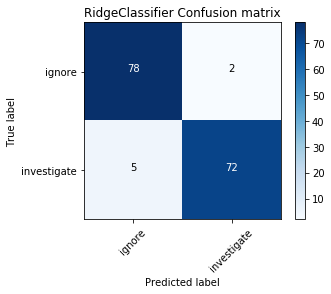

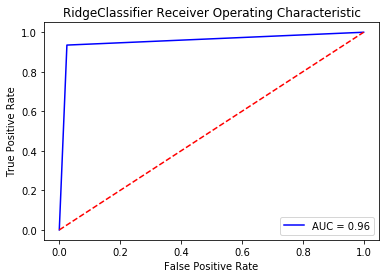

In [57]:
display_conf_mat(rd_clf,test_feats,test_labels)
plot_roc_curve(rd_clf,test_feats,test_labels)

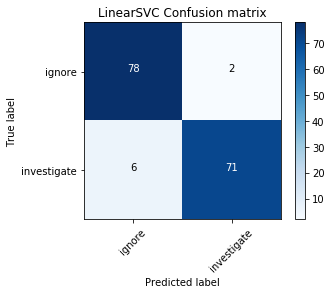

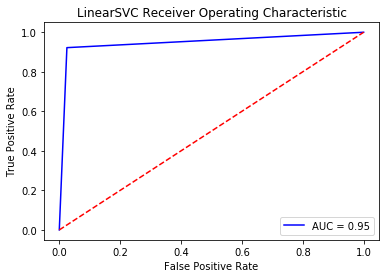

In [64]:
display_conf_mat(svm_clf,test_feats,test_labels)
plot_roc_curve(svm_clf,test_feats,test_labels)

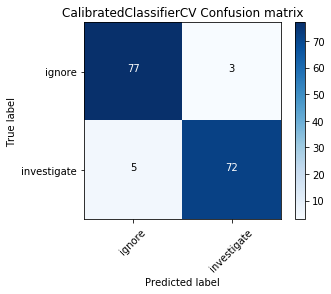

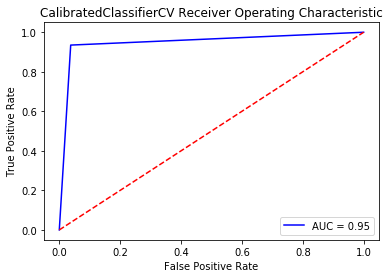

In [65]:
display_conf_mat(cc_clf,test_feats,test_labels)
plot_roc_curve(cc_clf,test_feats,test_labels)